In [1]:
import moth
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy
import scipy.signal
import h5py

sns.set_theme(context='poster')

PATH = '/storage/home/adz6/group/project'
DIGDATAPATH = os.path.join(PATH, 'datasets', 'data', 'lab', 'dig')
VNACORRECTION = os.path.join(PATH, 'results', 'moth', 'vna_correction_files')
VNADATAPATH = os.path.join(PATH, 'datasets', 'data', 'lab', 'vna')

#DAQDATAPATH = os.path.join(PATH, 'daq_data')
#MOTHPATH = os.path.join(PATH, 'moth')
#MOTHDATA = os.path.join(MOTHPATH, 'data/datasets')
#PLOTPATH = os.path.join(PATH, 'plots/moth')
#MOTHRESULTS = os.path.join(PATH, 'results/moth')

def CreateDataDictVNA(vna_trace_path, nch=120):
    
    file = h5py.File(vna_trace_path, 'r')
    
    try:
        data_dict = {}
        for i, key in enumerate(file.keys()):
            
            frequencies = file[key]['freq'][:]
            temp_array = file[key]['array'][:]
            data_dict[key] = temp_array[:, 0:nch, :]
            data_dict['freq'] = frequencies

        return data_dict
        
    except BaseException as err:
        
        print(err)
        file.close()
        return {}

    
def CreateDataDictDig(filepath, radial_indices = np.arange(0, 31, 1)):
    
    file = h5py.File(filepath, 'r')
    
    try:
        
        
        data_dict = {}
        for i, key in enumerate(file.keys()):
            #print(file[key].keys())
            temp_array = np.zeros((radial_indices.size, *file[key]['0'][:].shape), dtype=np.complex64)
            for irad in radial_indices:
                temp_array[irad, :] = file[key][f'{irad}'][:]
                
            data_dict[key] = temp_array
            
            
        file.close()
        
        return data_dict
        
    except BaseException as err:
        print(err)
        file.close()
        
        return {}
    
def FFTDataDictDig(data_dict):
    
    data_dict_fft = {}
    frequencies = np.fft.fftfreq(data_dict[list(data_dict.keys())[0]].shape[-1], 1 / 500e6)

    for i, key in enumerate(data_dict.keys()):
        data_dict_fft[key] = np.fft.fft(data_dict[key], axis=-1)
        
    data_dict_fft['freq'] = frequencies
    
    return data_dict_fft
    
def MagDataDictDig(data_dict_fft):
    
    mag_data_dict = {}
    
    for i, key in enumerate(data_dict_fft):
        if key == 'freq':
            pass
        else:
            mag_inds = np.argmax(abs(data_dict_fft[key]), axis=-1)
            
            mag_array = abs(data_dict_fft[key]).reshape((mag_inds.size, data_dict_fft[key].shape[-1]))[:, mag_inds.flatten() ]
            
            mag_data_dict[key] = np.diag(mag_array).reshape(mag_inds.shape) / data_dict_fft[key][0, 0, 1, :].shape[-1]
            
    return mag_data_dict

def AngleDataDictDig(data_dict_fft):
    
    angle_data_dict = {}
    
    for i, key in enumerate(data_dict_fft):
        if key == 'freq':
            pass
        else:
            mag_inds = np.argmax(abs(data_dict_fft[key]), axis=-1)
            
            angle_array = np.angle(data_dict_fft[key]).reshape((mag_inds.size, data_dict_fft[key].shape[-1]))[:, mag_inds.flatten() ]
            
            angle_data_dict[key] = np.diag(angle_array).reshape(mag_inds.shape)
            
    return angle_data_dict


In [2]:
os.listdir(VNADATAPATH)

['211206_cres2_vna_trace.h5',
 '211214_cres2_vna_trace_10slot.h5',
 '211220_cres2_vna_trace.h5',
 '211214_cres2_vna_trace.h5']

In [3]:
os.listdir(DIGDATAPATH)

['211213_cres2_meas_3ch_debug.h5',
 '211202_cres2_3ch_horn_offaxis_sweep.h5',
 '211213_cres2_meas_3ch.h5',
 '211213_cres2_meas_3ch_10slot.h5']

In [4]:
os.listdir(VNACORRECTION)

['220119_cres2_vna_correction_10slot.h5',
 '220119_cres2_vna_correction.h5',
 '220114_cres2_vna_correction.h5',
 '220114_cres2_vna_correction_10slot.h5']

In [5]:
dig_data_file = os.path.join(DIGDATAPATH, '211213_cres2_meas_3ch.h5')
vna_data_file = os.path.join(VNADATAPATH, '211220_cres2_vna_trace.h5')

In [6]:
data_dict_dig = CreateDataDictDig(dig_data_file)

data_dict_vna = CreateDataDictVNA(vna_data_file)
data_dict_fft = FFTDataDictDig(data_dict_dig)



# get frequency of digitizer data/VNA data

In [7]:
#plt.figure(figsize = (13, 8))

f_lo = 25.81e9
for i, key in enumerate(data_dict_fft.keys()):
    
    if i == 0:
        for ichan in [0]:
            #plt.plot(data_dict_fft['freq'], abs(data_dict_fft[key][0, ichan, 1, :]) / data_dict_fft[key][0, ichan, 1, :].shape[-1])
            dig_frequency = data_dict_fft['freq'][data_dict_fft[key][0, ichan, 1, :].argmax()]
            print(f'Digitizer frequency = {round(dig_frequency * 1e-6, 4)} MHz')
    else:
        pass
    
print(f'Nearest VNA freq = {data_dict_vna["freq"][np.argmin(abs(data_dict_vna["freq"] - dig_frequency - f_lo))]}')
ifreq = np.argmin(abs(data_dict_vna["freq"] - dig_frequency - f_lo))


Digitizer frequency = 63.9996 MHz
Nearest VNA freq = 25873999708.16


# compare properly processed phases between VNA and digitizer

In [8]:
data_dict_angle  = AngleDataDictDig(data_dict_fft)

In [9]:
average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][0, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][0, :, ifreq])
    
average_mag_vna /= 5
    

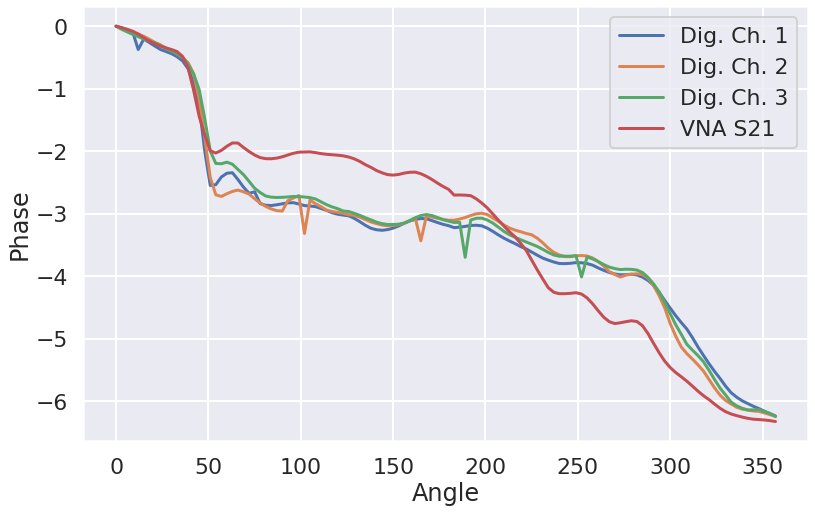

In [10]:
roll_list = [-59, -29 , 0]

plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):
    temp_phases = np.zeros(120)
    for i, key in enumerate(data_dict_angle):
        #print(key)
        
        temp_phases += np.unwrap(np.roll(data_dict_angle[key][0, :, iantenna+1], roll_list[iantenna])) - np.unwrap(np.roll(data_dict_angle[key][0, :, iantenna+1], roll_list[iantenna]))[0]
    temp_phases /= len(list(data_dict_angle.keys()))
    plt.plot(np.arange(0, 360, 3), temp_phases, label = f'Dig. Ch. {iantenna+1}')

    
plt.plot(np.arange(0, 360, 3), average_phases_vna, label = 'VNA S21')
plt.xlabel('Angle')
plt.ylabel('Phase')
plt.legend(loc=0)

# compare properly processed amplitudes between VNA and digitizer

In [11]:
data_dict_mag = MagDataDictDig(data_dict_fft)

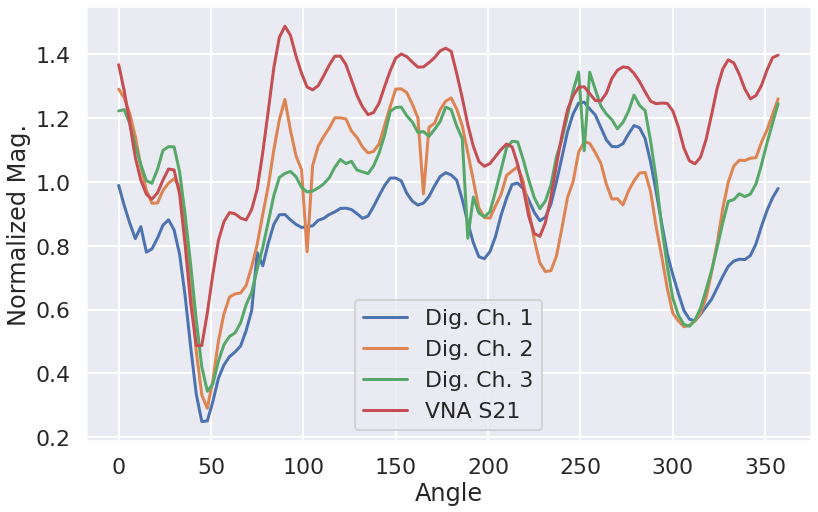

In [12]:
iantenna = 3
roll_list = [-59, -29 , 0]


plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):

    average_magnitudes = np.zeros(120)
    for i, key in enumerate(data_dict_mag):
        average_magnitudes += data_dict_mag[key][0, :, iantenna + 1]

    average_magnitudes /= len(list(data_dict_mag.keys()))



    plt.plot(np.arange(0, 360, 3), np.roll(average_magnitudes / (average_magnitudes.max() - average_magnitudes.min()), roll_list[iantenna]), label = f'Dig. Ch. {iantenna + 1}')
    
plt.plot(np.arange(0, 360, 3), average_mag_vna / (average_mag_vna.max() - average_mag_vna.min()), label='VNA S21')
plt.xlabel('Angle')
plt.ylabel('Normalized Mag.')
plt.legend(loc=0)

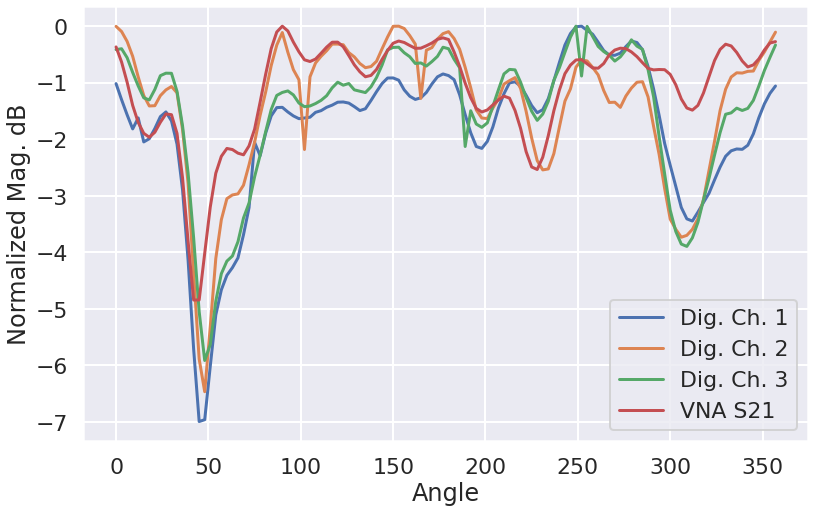

In [13]:
iantenna = 3
roll_list = [-59, -29 , 0]


plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):

    average_magnitudes = np.zeros(120)
    for i, key in enumerate(data_dict_mag):
        average_magnitudes += data_dict_mag[key][0, :, iantenna + 1]

    average_magnitudes /= len(list(data_dict_mag.keys()))

    plt.plot(np.arange(0, 360, 3), 10 * np.log10(np.roll(average_magnitudes / (average_magnitudes.max()), roll_list[iantenna])), label = f'Dig. Ch. {iantenna + 1}')
    
plt.plot(np.arange(0, 360, 3), 10 * np.log10(average_mag_vna / (average_mag_vna.max())), label='VNA S21')
plt.xlabel('Angle')
plt.ylabel('Normalized Mag. dB')
plt.legend(loc=0)

# investigate off-axis data, compare VNA to digitizer

# phases

In [14]:
iradius = 10

average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][iradius, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][iradius, :, ifreq])
    
average_mag_vna /= 5



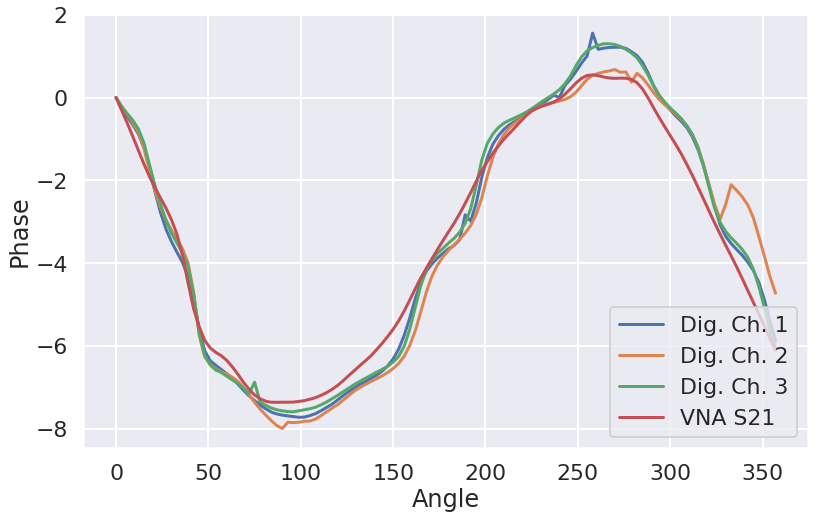

In [15]:
roll_list = [-59, -29 , 0]

plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):
    temp_phases = np.zeros(120)
    for i, key in enumerate(data_dict_angle):
        #print(key)
        if i == 0:
            reference_phase = np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna]))[0]
        
        temp_phases += np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna])) - (np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna]))[0])
    temp_phases /= len(list(data_dict_angle.keys()))
    plt.plot(np.arange(0, 360, 3), temp_phases, label = f'Dig. Ch. {iantenna+1}')

    
plt.plot(np.arange(0, 360, 3), average_phases_vna, label = 'VNA S21')
plt.xlabel('Angle')
plt.ylabel('Phase')
plt.legend(loc=0)

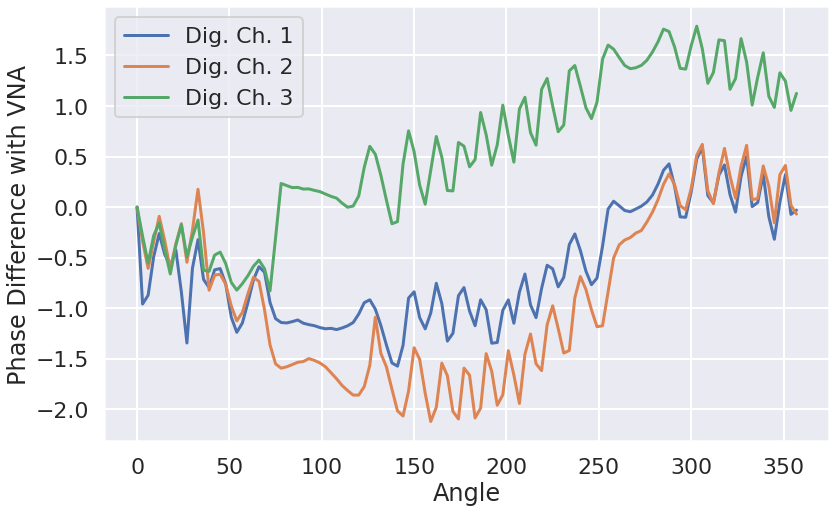

In [21]:
iradius = 30

average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][iradius, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][iradius, :, ifreq])
    
average_mag_vna /= 5


roll_list = [-59, -29, 0]

plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):
    temp_phases = np.zeros(120)
    for i, key in enumerate(data_dict_angle):
        if i == 0:
            reference_phase = np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna]))[0]
        #print(key)
        
        temp_phases += np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna])) - (np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1],roll_list[iantenna]))[0])
    temp_phases /= len(list(data_dict_angle.keys()))
    plt.plot(np.arange(0, 360, 3), temp_phases - average_phases_vna, label = f'Dig. Ch. {iantenna+1}')

    
#plt.plot(np.arange(0, 360, 3), average_phases_vna, label = 'VNA S21')
plt.xlabel('Angle')
plt.ylabel('Phase Difference with VNA')
plt.legend(loc=0)

# calculate the average differences for between the VNA phases and the digitizer phases for r=0, use this as a correction for the other off-axis data

In [17]:
iradius = 0

average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][iradius, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][iradius, :, ifreq])
    
average_mag_vna /= 5


roll_list = [-59, -29, 0]

correction_phases = np.zeros(120)
for iantenna in np.arange(0, 3, 1):
    temp_phases = np.zeros(120)
    for i, key in enumerate(data_dict_angle):
        if i == 0:
            reference_phase = np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna]))[0]
        #print(key)
        
        temp_phases += np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna])) - (np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1],roll_list[iantenna]))[0])
    temp_phases /= len(list(data_dict_angle.keys()))
    correction_phases += temp_phases - average_phases_vna
    
correction_phases /= 3


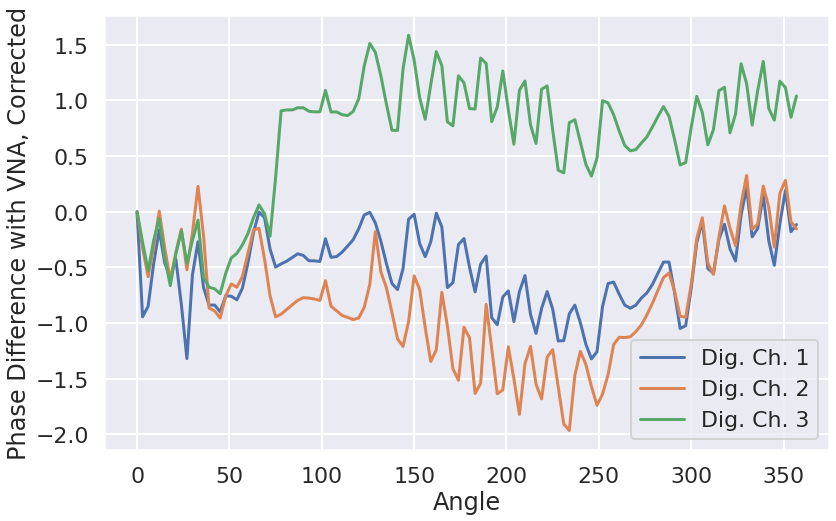

In [20]:
iradius = 30

average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][iradius, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][iradius, :, ifreq])
    
average_mag_vna /= 5


roll_list = [-59, -29, 0]

plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):
    temp_phases = np.zeros(120)
    for i, key in enumerate(data_dict_angle):
        if i == 0:
            reference_phase = np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna]))[0]
        #print(key)
        
        temp_phases += np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1], roll_list[iantenna])) - (np.unwrap(np.roll(data_dict_angle[key][iradius, :, iantenna+1],roll_list[iantenna]))[0])
    temp_phases /= len(list(data_dict_angle.keys()))
    plt.plot(np.arange(0, 360, 3), temp_phases - average_phases_vna - correction_phases, label = f'Dig. Ch. {iantenna+1}')

    
#plt.plot(np.arange(0, 360, 3), average_phases_vna, label = 'VNA S21')
plt.xlabel('Angle')
plt.ylabel('Phase Difference with VNA, Corrected')
plt.legend(loc=0)

# magnitudes

In [ ]:
iradius = 30


average_phases_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        #print(key)
        average_phases_vna += np.unwrap(np.angle(data_dict_vna[key][iradius, :, ifreq], ))
    
average_phases_vna /= 5
average_phases_vna -= average_phases_vna[0]

average_mag_vna = np.zeros(120)
for i, key in enumerate(data_dict_vna):
    if key == 'freq':
        pass
    else:
        average_mag_vna += abs(data_dict_vna[key][iradius, :, ifreq])
    
average_mag_vna /= 5



iantenna = 3
roll_list = [-59, -29 , 0]


plt.figure(figsize=(13, 8))

for iantenna in np.arange(0, 3, 1):

    average_magnitudes = np.zeros(120)
    for i, key in enumerate(data_dict_mag):
        average_magnitudes += data_dict_mag[key][iradius, :, iantenna + 1]

    average_magnitudes /= len(list(data_dict_mag.keys()))

    plt.plot(np.arange(0, 360, 3), 10 * np.log10(np.roll(average_magnitudes / (average_magnitudes.max()), roll_list[iantenna])), label = f'Dig. Ch. {iantenna + 1}')
    
plt.plot(np.arange(0, 360, 3), 10 * np.log10(average_mag_vna / (average_mag_vna.max())), label='VNA S21')
plt.xlabel('Angle')
plt.ylabel('Normalized Mag. dB')
plt.legend(loc=0)